In [1]:
import torch
import torch.nn as nn
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#Adapted from https://github.com/Jianbo-Lab/HSJA

class Normalize(nn.Module):
    def __init__(self, mean, std) :
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))
        
    def forward(self, input):
        # Broadcasting
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std


norm_layer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
weights = ResNet50_Weights.DEFAULT

model = nn.Sequential(
    norm_layer,
    resnet50(weights=weights))


model = model.to(device)
if device == 'cuda':
    model = torch.nn.DataParallel(model)

model = model.eval()

black swan: 47.5%
Top-K labels: [100 146  99  22  80]


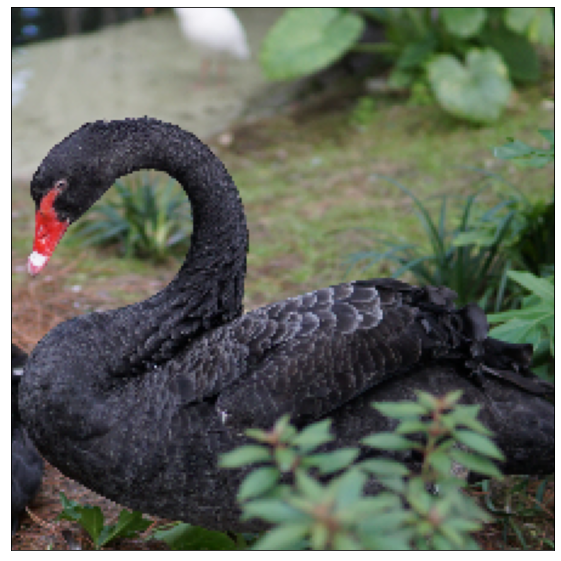

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as T


plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False,figsize=(10, 10))
    for i, img in enumerate(imgs):
        img = T.ToPILImage()(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


transform = T.Compose([
    T.Resize((224, 224)),
    T.Normalize(mean=[0, 0, 0], std=[255.0, 255.0, 255.0]),
    
])

        
img = read_image('images/black_swan.jpeg')
#img = read_image('images/macaw.jpg')
#show([img])
batch = transform(img.float()).unsqueeze(0)
show(batch)


prediction = model(batch).squeeze(0).softmax(0)

class_id = prediction.argmax().item()
score = prediction[class_id].item()
category_name = weights.meta["categories"][class_id]
print(f"{category_name}: {100 * score:.1f}%")
print("Top-K labels:",prediction.topk(5)[1].cpu().numpy())


In [3]:
def clip_image(image, clip_min, clip_max):
    # Clip an image, or an image batch, with upper and lower threshold.
    return np.minimum(np.maximum(clip_min, image), clip_max)




def project(original_image, perturbed_images, alphas, params):
    alphas_shape = [len(alphas)] + [1]*len(params['shape'])
    alphas = alphas.reshape(alphas_shape)

    if params['constraint'] == 'l2':
        return (1-alphas) * original_image + alphas * perturbed_images
    elif params['constraint'] == 'linf':
        out_images = clip_image(perturbed_images, original_image - alphas,original_image + alphas)
        return out_images




def decision_function(model, images, params):
    """
    Decision function output 1 on the desired side of the boundary,
    0 otherwise.
    """
    images = clip_image(images, params['clip_min'], params['clip_max'])
    batch_size = params['batch_size']
    size = images.shape[0]
    resultNP = np.zeros(0)
    for i in range(0,int(size/batch_size)+1):
        mini = batch_size*i
        maxi = min(batch_size*(i+1),size)
        #print(i,mini,maxi)
        img = torch.from_numpy(images[mini:maxi]).float().to(device)
        prob = model(img).cpu().detach().numpy()

        if params['target_label'] is None:
            resultNP = np.concatenate((resultNP,(np.argmax(prob, axis = 1) != params['original_label'])))
        else:
            resultNP = np.concatenate((resultNP,(np.argmax(prob, axis = 1) == params['target_label'])))
    return resultNP





def initialize(model, sample, params):
    """
    Efficient Implementation of BlendedUniformNoiseAttack in Foolbox.
    """
    success = 0
    num_evals = 0

    if params['target_image'] is None:
        # Find a misclassified random noise.
        while True:
            random_noise = np.random.uniform(params['clip_min'], params['clip_max'], size = params['shape'])
            success = decision_function(model,random_noise[None], params)[0]
            num_evals += 1
            if success:
                break
            assert num_evals < 1e4,"Initialization failed! "
            "Use a misclassified image as `target_image`"

        # Binary search to minimize l2 distance to original image.
        low = 0.0
        high = 1.0
        while high - low > 0.001:
            mid = (high + low) / 2.0
            blended = (1 - mid) * sample+ mid * random_noise
            success = decision_function(model, blended[None], params)
            if success:
                high = mid
            else:
                low = mid
        initialization = (1 - high) * sample + high * random_noise
    else:
        initialization = params['target_image']
    return initialization


def compute_distance(x_ori, x_pert, constraint = 'l2'):
    # Compute the distance between two images.
    if constraint == 'l2':
        return np.linalg.norm(x_ori - x_pert)
    elif constraint == 'linf':
        return np.max(abs(x_ori - x_pert))


def binary_search_batch(original_image, perturbed_images, model, params):
    """ Binary search to approach the boundary. """

    # Compute distance between each of perturbed image and original image.
    dists_post_update = np.array([compute_distance(original_image, perturbed_image, params['constraint'])
                                  for perturbed_image in perturbed_images])

    # Choose upper thresholds in binary searchs based on constraint.
    if params['constraint'] == 'linf':
        highs = dists_post_update
        # Stopping criteria.
        thresholds = np.minimum(dists_post_update * params['theta'], params['theta'])
    else:
        highs = np.ones(len(perturbed_images))
        thresholds = params['theta']

    lows = np.zeros(len(perturbed_images))

    # Call recursive function.
    while np.max((highs - lows) / thresholds) > 1:
        # projection to mids.
        mids = (highs + lows) / 2.0
        #print(perturbed_images.shape)
        mid_images = project(original_image, perturbed_images, mids, params)
        # Update highs and lows based on model decisions.
        decisions = decision_function(model, mid_images, params)
        lows = np.where(decisions == 0, mids, lows)
        highs = np.where(decisions == 1, mids, highs)

    out_images = project(original_image, perturbed_images, highs, params)

    # Compute distance of the output image to select the best choice.
    # (only used when stepsize_search is grid_search.)
    dists = np.array([
        compute_distance(original_image, out_image, params['constraint'])
        for out_image in out_images])
    idx = np.argmin(dists)

    dist = dists_post_update[idx]
    out_image = out_images[idx]
    return out_image, dist



def select_delta(params, dist_post_update):
    """
    Choose the delta at the scale of distance
    between x and perturbed sample.
    """
    if params['cur_iter'] == 1:
        delta = 0.1 * (params['clip_max'] - params['clip_min'])
    else:
        if params['constraint'] == 'l2':
            delta = np.sqrt(params['d']) * params['theta'] * dist_post_update
        elif params['constraint'] == 'linf':
            delta = params['d'] * params['theta'] * dist_post_update
    return delta



def approximate_gradient(model, sample, num_evals, delta, params):
    clip_max, clip_min = params['clip_max'], params['clip_min']

    # Generate random vectors.
    noise_shape = [num_evals] + list(params['shape'])

    #print("Noise shape:",noise_shape)
    if params['constraint'] == 'l2':
        rv = np.random.randn(*noise_shape)
    elif params['constraint'] == 'linf':
        rv = np.random.uniform(low = -1, high = 1, size = noise_shape)

    rv = rv / np.sqrt(np.sum(rv ** 2, axis = (1,2,3), keepdims = True))
    perturbed = sample + delta * rv
    perturbed = clip_image(perturbed, clip_min, clip_max)
    rv = (perturbed - sample) / delta

    # query the model.
    decisions = decision_function(model, perturbed, params)

    decision_shape = [len(decisions)] + [1] * len(params['shape'])
    fval = 2 * decisions.astype(float).reshape(decision_shape) - 1.0


    # Baseline subtraction (when fval differs)
    if np.mean(fval) == 1.0: # label changes.
        gradf = np.mean(rv, axis = 0)
    elif np.mean(fval) == -1.0: # label not change.
        gradf = - np.mean(rv, axis = 0)
    else:
        fval -= np.mean(fval)
        gradf = np.mean(fval * rv, axis = 0)

    # Get the gradient direction.
    gradf = gradf / np.linalg.norm(gradf)

    return gradf


def geometric_progression_for_stepsize(x, update, dist, model, params):
    """
    Geometric progression to search for stepsize.
    Keep decreasing stepsize by half until reaching
    the desired side of the boundary,
    """
    epsilon = dist / np.sqrt(params['cur_iter'])

    def phi(epsilon):
        new = x + epsilon * update
        success = decision_function(model, new[None], params)
        return success

    while not phi(epsilon):
        epsilon /= 2.0
    return epsilon




def hsja(model, sample, clip_max = 1, clip_min = 0, constraint = 'l2', num_iterations = 40,
         gamma = 1.0, target_label = None, target_image = None, stepsize_search = 'geometric_progression',
         max_num_evals = 1e4,batch_size = 260,init_num_evals = 100, verbose = True):
    """
    Inputs:
    model: the object that has a predict method. predict outputs probability scores.
    clip_max: upper bound of the image.
    clip_min: lower bound of the image.
    constraint: choose between [l2, linf].
    num_iterations: number of iterations.
    gamma: used to set binary search threshold theta. The binary search
    threshold theta is gamma / d^{3/2} for l2 attack and gamma / d^2 for linf attack.
    target_label: integer or None for nontargeted attack.
    target_image: an array with the same size as sample, or None.
    stepsize_search: choose between 'geometric_progression', 'grid_search'.
    max_num_evals: maximum number of evaluations for estimating gradient (for each iteration). This is not the
    total number of model evaluations for the entire algorithm, you need to set a counter of model evaluations
    by yourself to get that. To increase the total number of model evaluations, set a larger num_iterations.
    init_num_evals: initial number of evaluations for estimating gradient.

    Output:
    perturbed image.
     """



    original_label = np.argmax(model(torch.from_numpy(sample).float().to(device)).cpu().detach().numpy())
    params = {'clip_max': clip_max, 'clip_min': clip_min,
                'shape': sample.shape,
                'original_label': original_label,
                'target_label': target_label,
                'target_image': target_image,
                'constraint': constraint,
                'num_iterations': num_iterations,
                'gamma': gamma,
                'd': int(np.prod(sample.shape)),
                'stepsize_search': stepsize_search,
                'max_num_evals': max_num_evals,
                'batch_size': batch_size,
                'init_num_evals': init_num_evals,
                'verbose': verbose,}

    # Set binary search threshold.
    if params['constraint'] == 'l2':
        params['theta'] = params['gamma'] / (np.sqrt(params['d']) * params['d'])
    else:
        params['theta'] = params['gamma'] / (params['d'] ** 2)

    perturbed = initialize(model, sample, params)



    # Project the initialization to the boundary.

    perturbed, dist_post_update = binary_search_batch(sample,
        perturbed, model, params)

    dist = compute_distance(perturbed, sample, constraint)


    for j in np.arange(params['num_iterations']):
        params['cur_iter'] = j + 1

        # Choose delta.
        delta = select_delta(params, dist_post_update)

        # Choose number of evaluations.
        num_evals = int(params['init_num_evals'] * np.sqrt(j+1))
        num_evals = int(min([num_evals, params['max_num_evals']]))

        # Choose number of evaluations.
        num_evals = int(params['init_num_evals'] * np.sqrt(j+1))
        num_evals = int(min([num_evals, params['max_num_evals']]))

        # approximate gradient.
        gradf = approximate_gradient(model, perturbed, num_evals, delta, params)
        if params['constraint'] == 'linf':
            update = np.sign(gradf)
        else:
            update = gradf

        # search step size.
        if params['stepsize_search'] == 'geometric_progression':
            # find step size.
            epsilon = geometric_progression_for_stepsize(perturbed, update, dist, model, params)

            # Update the sample.
            perturbed = clip_image(perturbed + epsilon * update, clip_min, clip_max)

            # Binary search to return to the boundary.
            perturbed, dist_post_update = binary_search_batch(sample, perturbed[None], model, params)

        elif params['stepsize_search'] == 'grid_search':
            # Grid search for stepsize.
            epsilons = np.logspace(-4, 0, num=20, endpoint = True) * dist
            epsilons_shape = [20] + len(params['shape']) * [1]
            perturbeds = perturbed + epsilons.reshape(epsilons_shape) * update
            perturbeds = clip_image(perturbeds, params['clip_min'], params['clip_max'])
            idx_perturbed = decision_function(model, perturbeds, params)

            if np.sum(idx_perturbed) > 0:
                # Select the perturbation that yields the minimum distance # after binary search.
                perturbed, dist_post_update = binary_search_batch(sample, perturbeds[idx_perturbed], model, params)


        # compute new distance.
        dist = compute_distance(perturbed, sample, constraint)
        if verbose:
            print('iteration: {:d}, {:s} distance {:.4E}'.format(j+1, constraint, dist))

    return perturbed



pert_data = hsja(model,
                 batch.numpy()[0],
                 clip_max = 1,
                 clip_min = 0,
                 constraint = 'l2',
                 #constraint = 'linf',
                 num_iterations = 64,
                 gamma = 1.0,
                 target_label = None,
                 target_image = None,
                 stepsize_search = 'geometric_progression',
                 max_num_evals = 1e4,
                 batch_size = 200,
                 init_num_evals = 100)


iteration: 1, l2 distance 7.4351E+01
iteration: 2, l2 distance 6.3589E+01
iteration: 3, l2 distance 5.8869E+01
iteration: 4, l2 distance 5.6284E+01
iteration: 5, l2 distance 5.0203E+01
iteration: 6, l2 distance 4.4354E+01
iteration: 7, l2 distance 4.1780E+01
iteration: 8, l2 distance 3.9413E+01
iteration: 9, l2 distance 3.6149E+01
iteration: 10, l2 distance 3.3372E+01
iteration: 11, l2 distance 3.0521E+01
iteration: 12, l2 distance 2.8784E+01
iteration: 13, l2 distance 2.6649E+01
iteration: 14, l2 distance 2.5080E+01
iteration: 15, l2 distance 2.3702E+01
iteration: 16, l2 distance 2.2129E+01
iteration: 17, l2 distance 2.0708E+01
iteration: 18, l2 distance 1.9537E+01
iteration: 19, l2 distance 1.8589E+01
iteration: 20, l2 distance 1.7276E+01
iteration: 21, l2 distance 1.6313E+01
iteration: 22, l2 distance 1.5211E+01
iteration: 23, l2 distance 1.4318E+01
iteration: 24, l2 distance 1.3425E+01
iteration: 25, l2 distance 1.2727E+01
iteration: 26, l2 distance 1.1956E+01
iteration: 27, l2 dis

In [6]:
perturbed_data = torch.tensor(pert_data)
prediction = model(perturbed_data.float()).squeeze(0).softmax(0)
class_id = prediction.argmax().item()
score = prediction[class_id].item()
category_name = weights.meta["categories"][class_id]


Min perturbation:  -14.0 , Max perturbation:  12.0
ram: 6.1%
Top-K labels: [348 100 658 806 349]


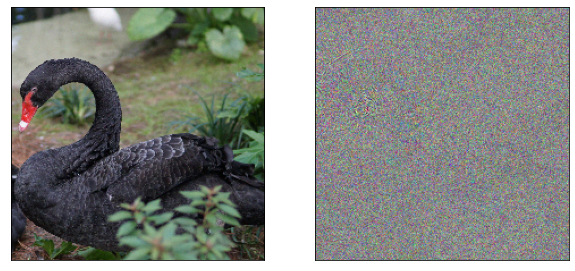

In [5]:
delta = batch[0]-perturbed_data
#show([perturbed_data])
a = delta.min().cpu().detach()
b = delta.max().cpu().detach()
print("Min perturbation: ",round(a.cpu().numpy()*255,0),", Max perturbation: ",round(b.cpu().numpy()*255,0))
print(f"{category_name}: {100 * score:.1f}%")
print("Top-K labels:",prediction.topk(5)[1].cpu().numpy())
scaledDelta = (delta-a)/(b-a)
show([perturbed_data,scaledDelta])
